#  Modeling count data using different observation models
Here we generate an artificial longitudinal data set and analyse it.

In [1]:
require(lgpr)
require(repr)
require(ggplot2)

Loading required package: lgpr

Hello, this is lgpr (version 0.28.5).

Loading required package: repr

Loading required package: ggplot2



## 1. Simulating data
In this example we generate count data with 10 individuals and 8 measurement time points for each. 

[1] 0 1 1 0 1 0
[1] 0.4106704
 [1]  0  1  0  0  0  0  0  4  0  0  0  0  0  0  1 10  0  0  0  0  0  0  1  0  0
[26]  0  0  0  0  0  1  1  1  0  0  0  0  3  1  0  0  0  0  0  0  0  8  2  0  0
[51]  1  1  1  3  0  1  0  0  0  0  0  0  3  1  0  0  2  1  2  5  2  9  0  0  0
[76]  0  0  0  0  0


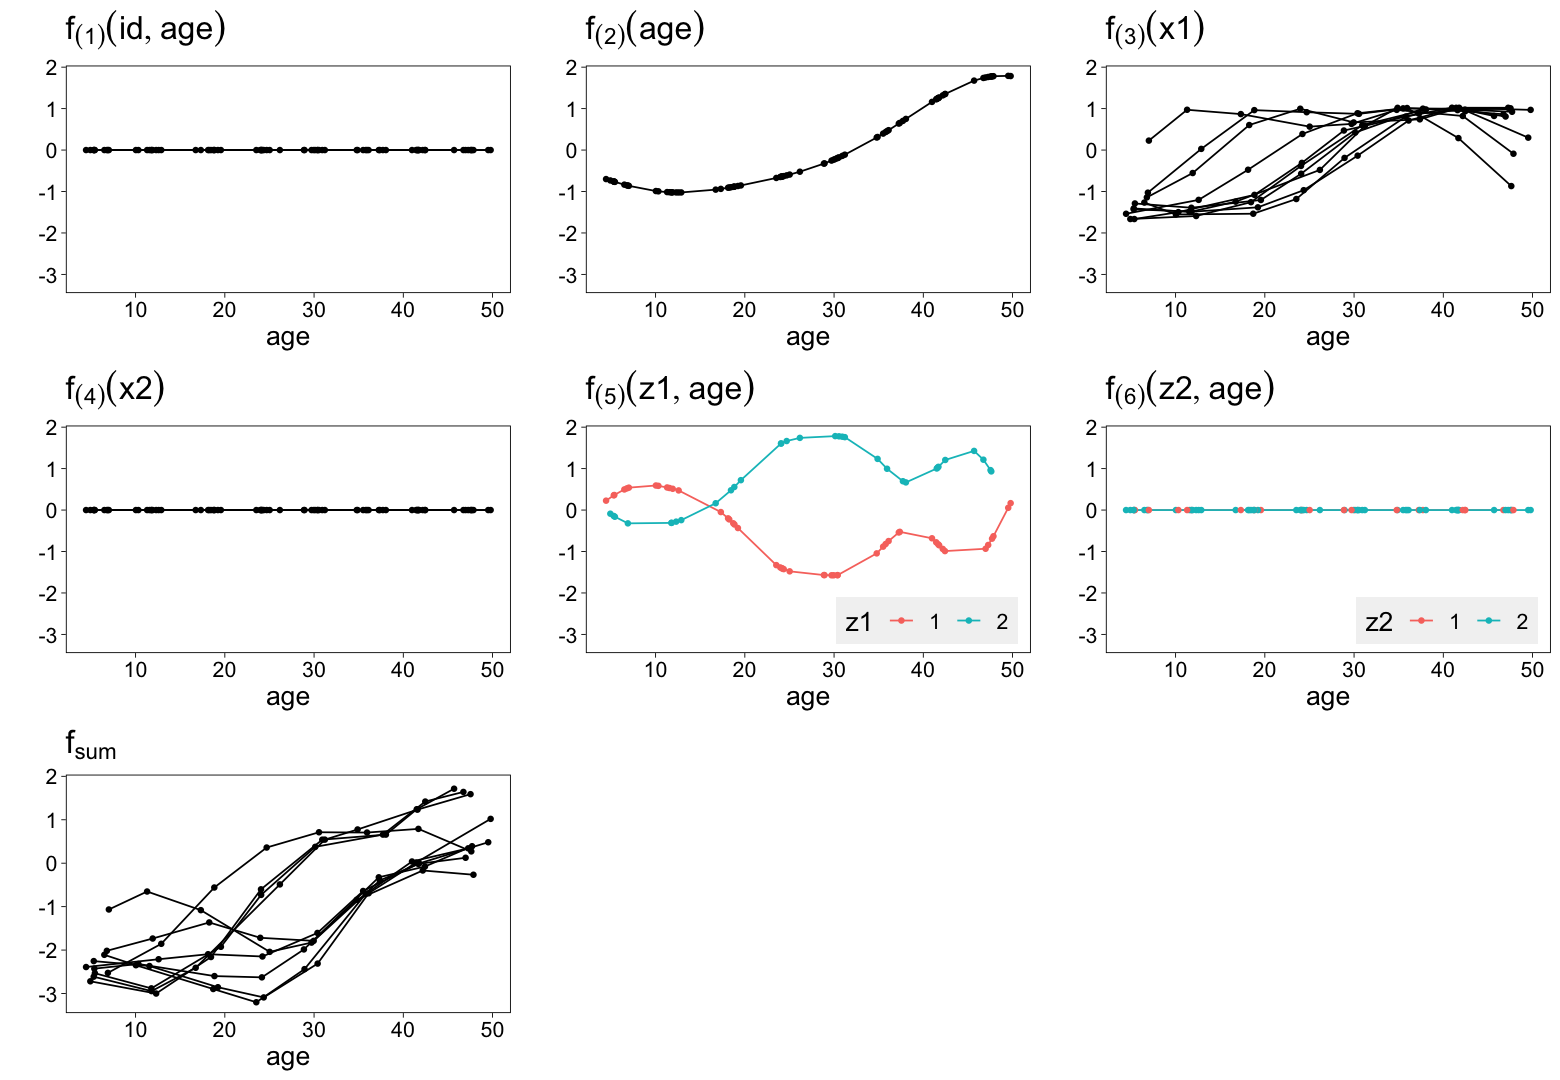

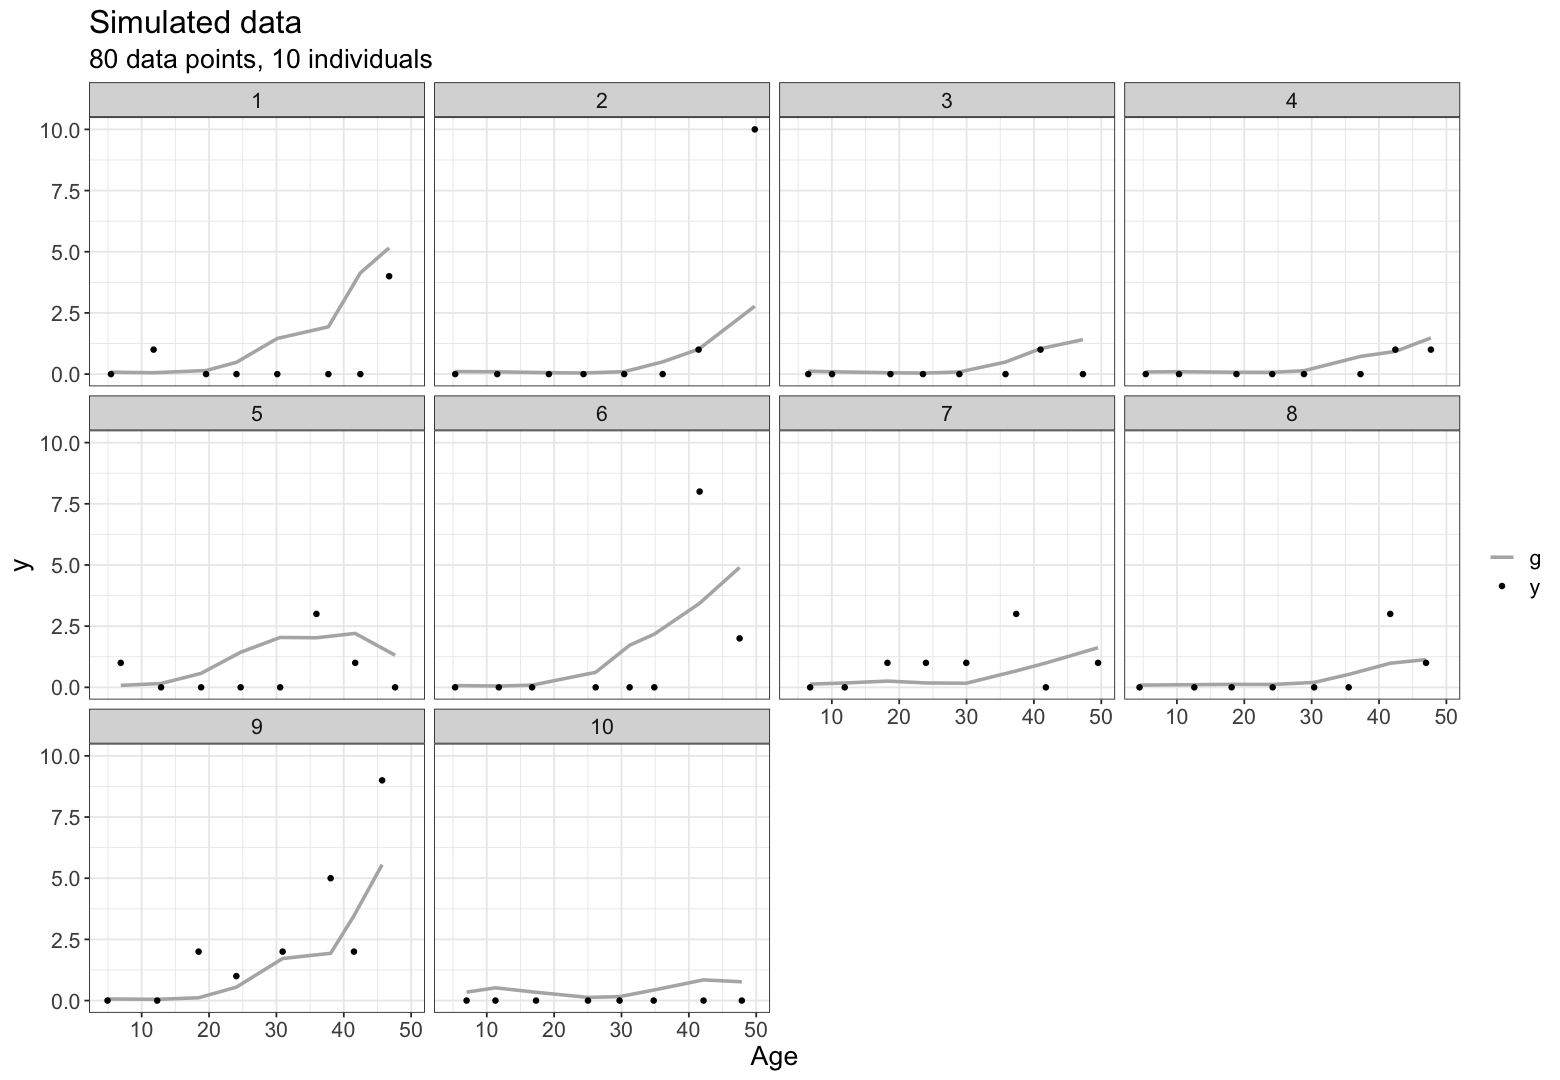

In [2]:
set.seed(123)
idx_num <- 1
if(idx_num <= 100){
  rel_real <- c(0,1,1,0,1,0)
}else if(idx_num > 100 && idx_num <= 200){
  rel_real <- c(1,1,1,0,1,0)
}else{
  rel_real <- c(0,0,1,1,0,0)
}
print(rel_real)
simData   <- simulate_data(N          = 10,
                         t_data       = seq(6, 48, by = 6),
                         covariates   = c(     1,1,2,2),
                         lengthscales = c(6,12,1,1,6,6),
                         relevances   = rel_real,
                         noise_type   = "NB",
                         phi          = 2,
                         C_hat        = -1,
                         f_var        = 2,
                         t_jitter     = 1)

p_signal <- simData$p_signal
print(p_signal)
print(simData$data$y)

options(repr.plot.width=13, repr.plot.height=9)
plot_components_simdata(simData, font_size = 16, time_is_xvar = TRUE)
plot_simdata(simData) + theme(text=element_text(size=16)) 

## 2. Fitting models
We fit three different models.

In [3]:
  N_ITER <- 2000
  CONTROL <- list(adapt_delta = 0.95)
  USE_PAR <- TRUE

  # gaussian model ----------------------------------------------------------

  f1 <- lgp(formula  = y ~ id + age + x1 + x2 + z1 + z2, 
          data     = simData$data,
          iter     = N_ITER, 
          parallel = USE_PAR, 
          chains   = 4,
          control  = CONTROL,
          save_warmup = FALSE,
           refresh = 0)


  # nb model ----------------------------------------------------------------

  f2 <- lgp(formula    = y ~ id + age +  x1 + x2 +  z1 + z2,
          data       = simData$data,
          likelihood = "NB",
          iter       = N_ITER, 
          parallel   = USE_PAR, 
          chains     = 4,
          control    = CONTROL,
          save_warmup = FALSE,
           refresh = 0)


  # log-gaussian model ------------------------------------------------------

  logdata    <- simData$data
  logdata$y  <- log(1 + logdata$y)

  f3 <- lgp(formula  = y ~ id + age + x1 + x2 + z1 + z2,
          data     = logdata,
          iter     = N_ITER, 
          parallel = USE_PAR, 
          chains   = 4,
          control  = CONTROL,
          save_warmup = FALSE,
           refresh = 0) 

  # Show results
  cat("\n\n")
  show(f1)
  show(f2)
  show(f3)





 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 70.51 s (warmup) and 61.48 s (sampling)
* Largest R-hat value is 1.0046 (F_mean_tot[1,67])
* Proportion of signal = 0.41
* Selection threshold = 0.95

                Relevance Selected
f[(1)](id, age)     0.075     TRUE
f[(2)](age)         0.184     TRUE
f[(3)](x1)          0.034     TRUE
f[(4)](x2)          0.022    FALSE
f[(5)](z1, age)     0.037     TRUE
f[(6)](z2, age)     0.058     TRUE
noise               0.590     TRUE


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 432.9 s (warmup) and 438.82 s (sampling)


Warning message in max(Rhat):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Rhat):
“no non-missing arguments to max; returning -Inf”


* Largest R-hat value is -Inf ()
* Proportion of signal = 0.492
* Selection threshold = 0.95

                Relevance Selected
f[(1)](id, age)     0.084     TRUE
f[(2)](age)         0.188     TRUE
f[(3)](x1)          0.061     TRUE
f[(4)](x2)          0.031    FALSE
f[(5)](z1, age)     0.060     TRUE
f[(6)](z2, age)     0.067     TRUE
noise               0.508     TRUE


 ---------- LGPFIT SUMMARY ----------

* Average runtime per chain: 60.76 s (warmup) and 48.63 s (sampling)
* Largest R-hat value is 1.0034 (F_mean_cmp[1,1,23])
* Proportion of signal = 0.51
* Selection threshold = 0.95

                Relevance Selected
f[(1)](id, age)     0.106     TRUE
f[(2)](age)         0.231     TRUE
f[(3)](x1)          0.045     TRUE
f[(4)](x2)          0.024    FALSE
f[(5)](z1, age)     0.037     TRUE
f[(6)](z2, age)     0.068     TRUE
noise               0.490     TRUE



## 3. Component relevances

The averaged component relevances for each model are reported above. 

## 4. Selection probabilities

In [6]:
s1 <- selection_prob(f1, h = 0.001)
s2 <- selection_prob(f2, h = 0.001)
s3 <- selection_prob(f3, h = 0.001)

We can visualize the selection probability of each component as a function of the threshold.

f[(1)](id, age)     f[(2)](age)      f[(3)](x1)      f[(4)](x2) f[(5)](z1, age) 
         0.5571          0.9713          0.4354          0.3087          0.5568 
f[(6)](z2, age) 
         0.6649 


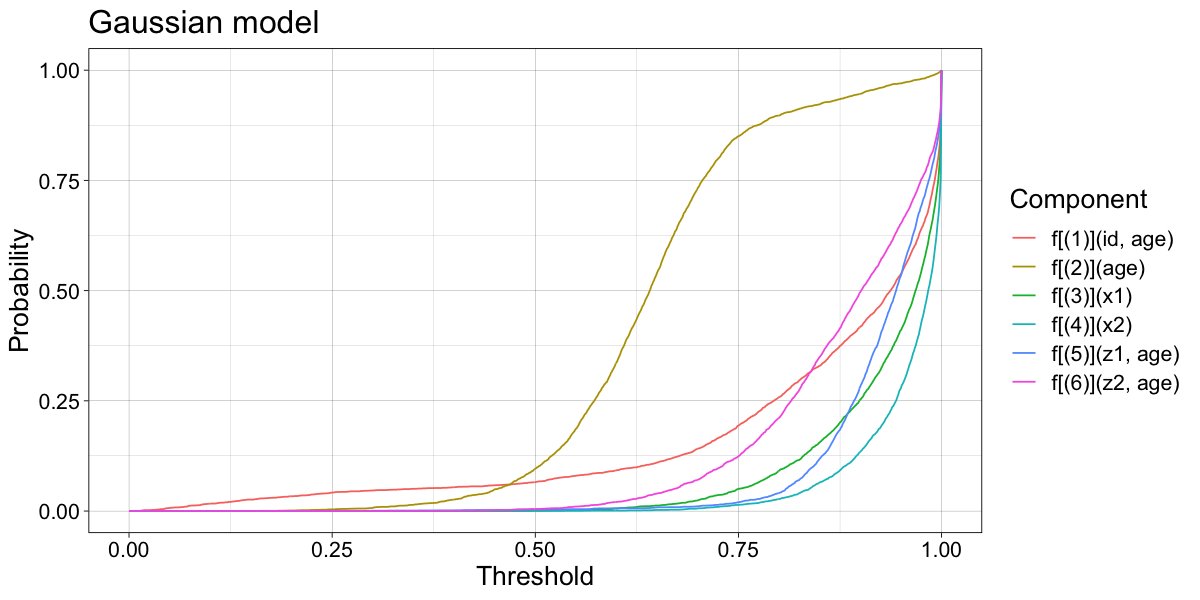

In [9]:
options(repr.plot.width=10, repr.plot.height=5)
print(round(s1$prob, 4)) # print selection probabilities, computed by weighing thresholds with Beta(100,5)
plt <- s1$plot + theme(text=element_text(size=16)) + ggtitle('Gaussian model')
plt

f[(1)](id, age)     f[(2)](age)      f[(3)](x1)      f[(4)](x2) f[(5)](z1, age) 
         0.6734          0.9457          0.5126          0.3453          0.6128 
f[(6)](z2, age) 
         0.6166 


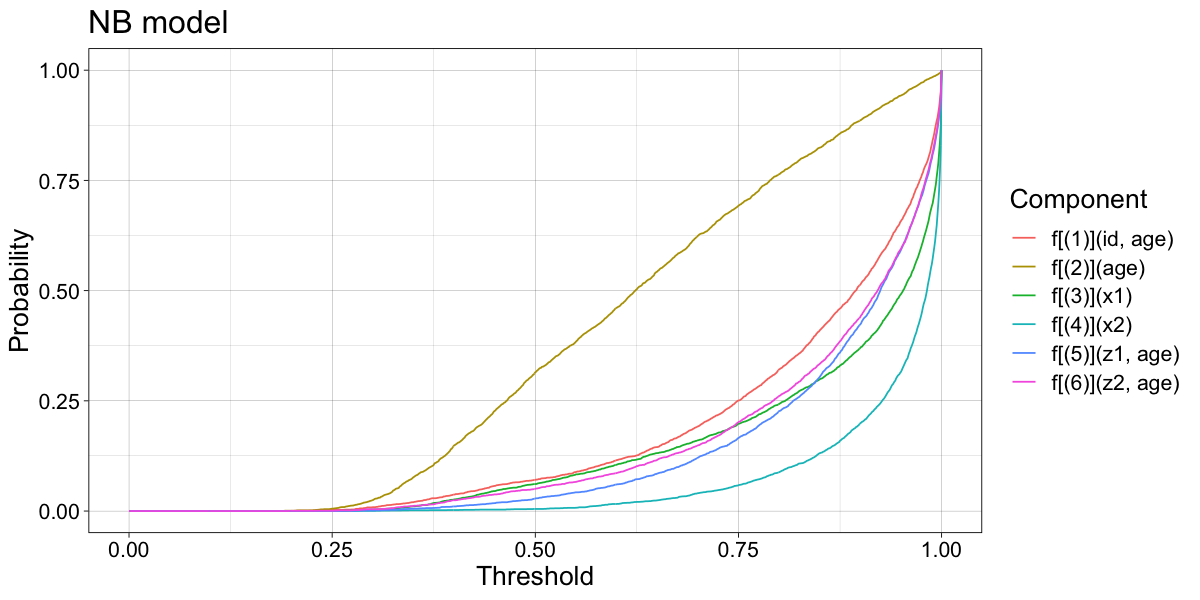

In [10]:
print(round(s2$prob, 4)) # print selection probabilities, computed by weighing thresholds with Beta(100,5)
plt <- s2$plot + theme(text=element_text(size=16)) + ggtitle('NB model')
plt

f[(1)](id, age)     f[(2)](age)      f[(3)](x1)      f[(4)](x2) f[(5)](z1, age) 
         0.7851          0.9911          0.5082          0.3174          0.5302 
f[(6)](z2, age) 
         0.7034 


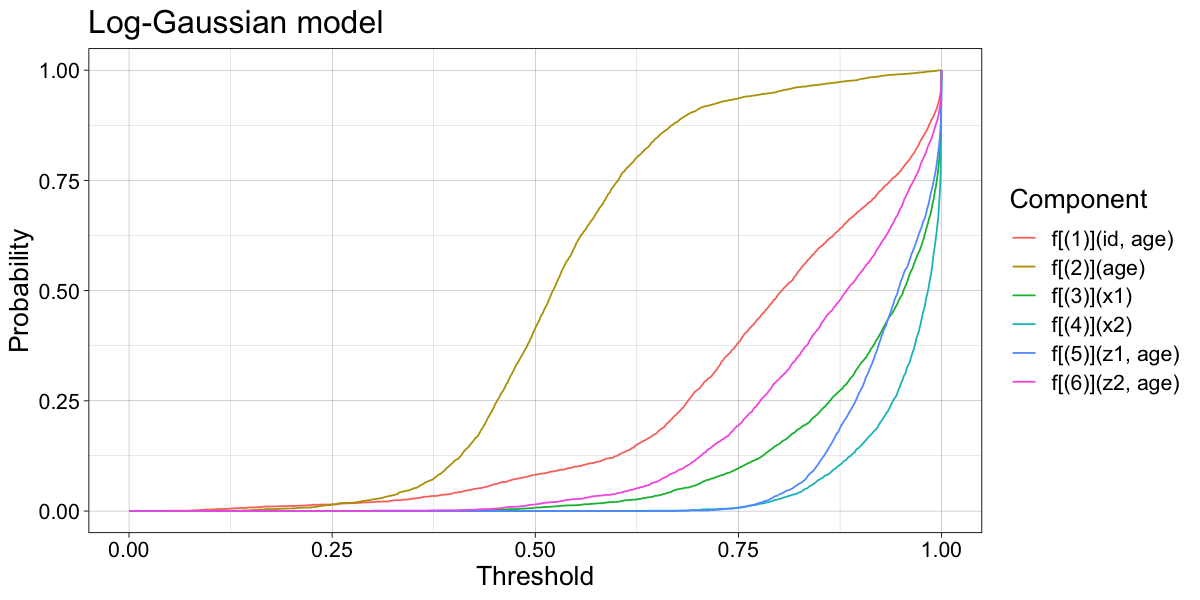

In [11]:
print(round(s3$prob, 4)) # print selection probabilities, computed by weighing thresholds with Beta(100,5)
plt <- s3$plot + theme(text=element_text(size=16)) + ggtitle('Log-Gaussian model')
plt